In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when,sum as spark_sum
import warnings
warnings.filterwarnings('ignore')

# Problem Statement 5: Sales Team Performance Assessment

**Objective**: Analyse sales team performance to identify high performers and areas needing improvement.

**Description:**
1.	Assess sales_team.csv to evaluate performance metrics such as sales achieved versus sales targets for each sales representative.
2.	Identify top performers and those who are underperforming relative to their targets.

**Expected Deliverables:**
- A performance report highlighting top sales representatives and those needing additional support or training.
- Actionable recommendations for improving overall sales performance.




In [29]:
%run utilities/bar_plot_with_line.ipynb
%run utilities/common_utility.ipynb

24/09/13 07:06:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/13 07:06:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Initialize Spark session

In [30]:
# Initialize Spark session
spark = initialize_spark_session("Sales Team Performance Assessment")

24/09/13 07:06:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Logs Configuration

In [31]:
log_file_path = 'logs/analysis.log'
logger = initialize_logger(log_file_path)

logger.info("Logger initialized with dynamic path!")

2024-09-13 07:06:19,861 - logger - INFO - Logger initialized with dynamic path!


# Load Dataset

In [32]:
sales_team_file_path = "Cleaned_data/cleaned_sales_team.csv"
sales_team_df = load_data_files(sales_team_file_path)

## Performance Ratio, Sales Percentage and Performance Status of Each Sales Representative

In [33]:
# Calculate the Performance Ratio (Sales_Achieved / Sales_Target)
sales_team_df = sales_team_df.withColumn("Performance_Ratio", col("Sales_Achieved") / col("Sales_Target"))

# Classify Performance Status (High Performer or Underperformer)
sales_team_df = sales_team_df.withColumn(
    "Performance_Status", 
    when(col("Performance_Ratio") >= 1, "High Performer").otherwise("Underperformer")
)
# Calculate the percentage of sales achieved relative to the target for each sales rep
sales_team_df = sales_team_df.withColumn('Sales_Percentage', (col('Sales_Achieved') / col('Sales_Target')) * 100)
# Display the updated DataFrame with Performance Ratio and Status
sales_team_df.show(5)

+--------------------+--------------------+------------+------------+--------------+-------------------+------------------+------------------+
|        Sales_Rep_ID|                Name|      Region|Sales_Target|Sales_Achieved|  Performance_Ratio|Performance_Status|  Sales_Percentage|
+--------------------+--------------------+------------+------------+--------------+-------------------+------------------+------------------+
|02acdbab-d149-405...|       Daniel Barber|     Arizona|       13651|        7296.0| 0.5344663394623105|    Underperformer|53.446633946231046|
|0437b05a-9628-43f...|     Brittany Taylor|  California|       41135|       14037.0|0.34124225112434664|    Underperformer|34.124225112434665|
|0468e32e-644b-491...|Dr. Wayne Spencer...|Pennsylvania|       15593|       37653.0|  2.414737382158661|    High Performer| 241.4737382158661|
|05cc8513-8a8a-459...|   Pamela Pennington|       Idaho|       38399|       11569.0|0.30128388760123964|    Underperformer|30.128388760123965|

# Sales Target vs Sales Achieved for Each Representative

2024-09-13 07:06:20,348 - logger - INFO - Sales Target vs Sales Achieved for Each Representative


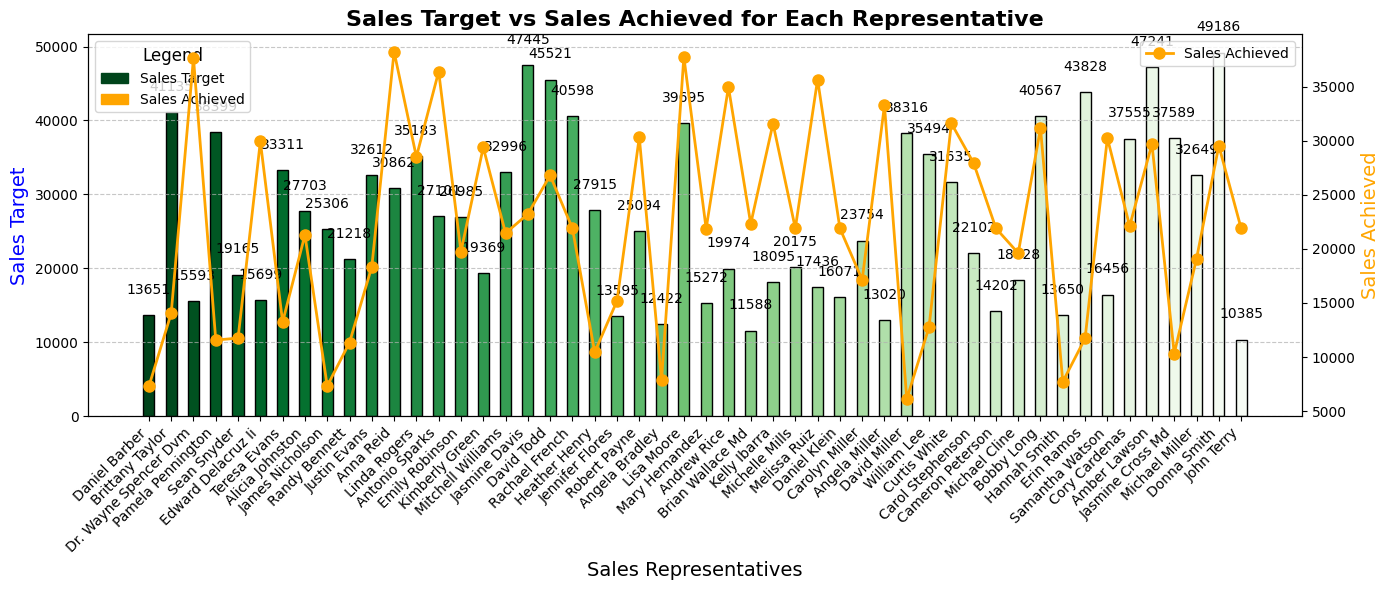

In [34]:

# Convert to Pandas for plotting
sales_team_pd_df = sales_team_df.toPandas()
logger.info("Sales Target vs Sales Achieved for Each Representative")
plot_dual_axis_bar_line(
    data_pd=sales_team_pd_df, 
    x_labels='Name', 
    bar_col='Sales_Target', 
    line_col='Sales_Achieved', 
    bar_label='Sales Target', 
    line_label='Sales Achieved', 
    title='Sales Target vs Sales Achieved for Each Representative', 
    x_title='Sales Representatives', 
    bar_y_title='Sales Target', 
    line_y_title='Sales Achieved', 
    rotation=45
)


# Idenytifying Top Performer and Under Performer

2024-09-13 07:06:20,969 - logger - INFO - High Performers (Performance Ratio >= 1)


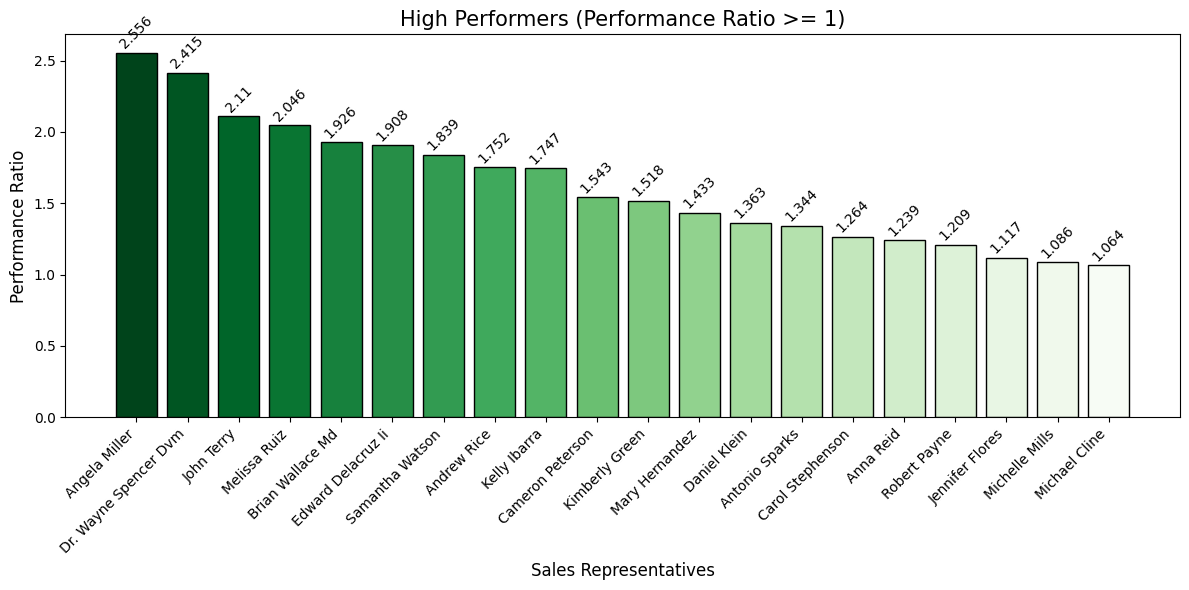

2024-09-13 07:06:21,149 - logger - INFO - Underperformers (Performance Ratio < 1)


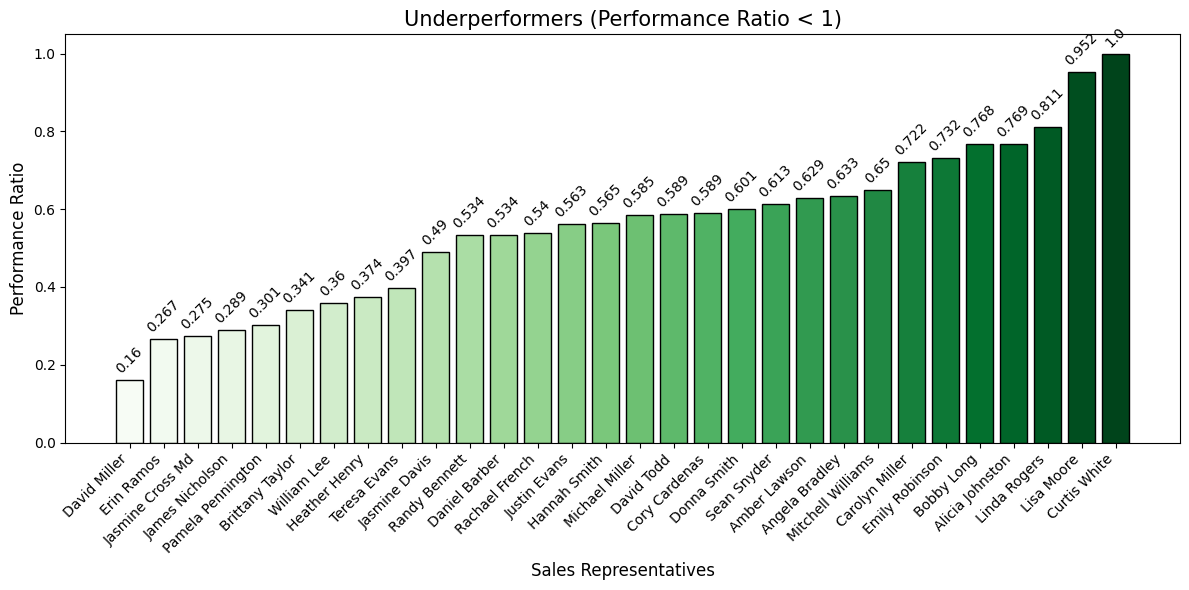

In [35]:

# Separate top performers and underperformers
top_performers_df = sales_team_df.filter(col("Performance_Ratio") >= 1).toPandas()
underperformers_df = sales_team_df.filter(col("Performance_Ratio") < 1).toPandas()

# Sort by Performance Ratio in descending order
top_performers_df = top_performers_df.sort_values(by='Performance_Ratio', ascending=False)
underperformers_df = underperformers_df.sort_values(by='Performance_Ratio', ascending=False)

logger.info("High Performers (Performance Ratio >= 1)")
plot_performers_bar_chart(
    df=top_performers_df, 
    title='High Performers (Performance Ratio >= 1)', 
    xlabel='Sales Representatives', 
    ylabel='Performance Ratio', 
    cmap='Greens', 
    color_inversion=True  # Invert colors for top performers
)

logger.info("Underperformers (Performance Ratio < 1)")
plot_performers_bar_chart(
    df=underperformers_df, 
    title='Underperformers (Performance Ratio < 1)', 
    xlabel='Sales Representatives', 
    ylabel='Performance Ratio', 
    cmap='Greens', 
    color_inversion=False
)


# Sales Team Performance by Region

2024-09-13 07:06:21,678 - logger - INFO - Sales Team Performance BY Region


+--------+--------------------+------------------+------------------+------------------+
|  Region|Total_Sales_Achieved|Total_Sales_Target| Performance_Ratio|Performance_Status|
+--------+--------------------+------------------+------------------+------------------+
|    Utah|            112756.0|            120092|0.9389134996502682|    Underperformer|
|  Hawaii|             30338.0|             25094|1.2089742567944528|    High Performer|
|    Ohio|            44029.43|             78153|0.5633747904750938|    Underperformer|
|  Oregon|             91110.0|             92281| 0.987310497285465|    Underperformer|
|Arkansas|             38252.0|             30862| 1.239453049057093|    High Performer|
+--------+--------------------+------------------+------------------+------------------+
only showing top 5 rows



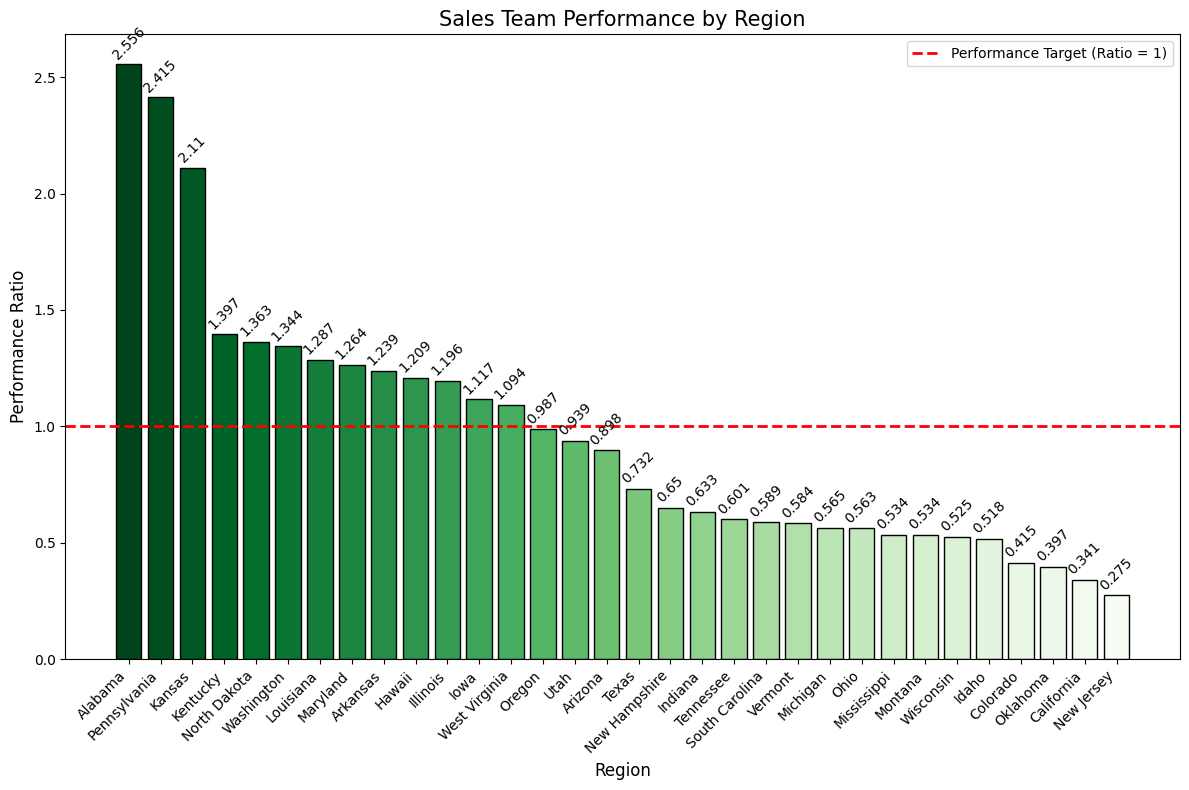

In [36]:

# Aggregate Sales_Achieved and Sales_Target by Region
region_performance_df = sales_team_df.groupBy("Region").agg(
    spark_sum("Sales_Achieved").alias("Total_Sales_Achieved"),
    spark_sum("Sales_Target").alias("Total_Sales_Target")
)

# Calculate the Performance Ratio (Total_Sales_Achieved / Total_Sales_Target) for each region
region_performance_df = region_performance_df.withColumn(
    "Performance_Ratio", col("Total_Sales_Achieved") / col("Total_Sales_Target")
)

# Classify regions as High Performer or Underperformer
region_performance_df = region_performance_df.withColumn(
    "Performance_Status", 
    when(col("Performance_Ratio") >= 1, "High Performer").otherwise("Underperformer")
)
region_performance_df.show(5)
logger.info("Sales Team Performance BY Region")
plot_region_performance(region_performance_df)


# Performance Report Highlighting Top 20 Sales Representatives

2024-09-13 07:06:22,173 - logger - INFO - Top 20 Performers: Sales Target vs Sales Achieved


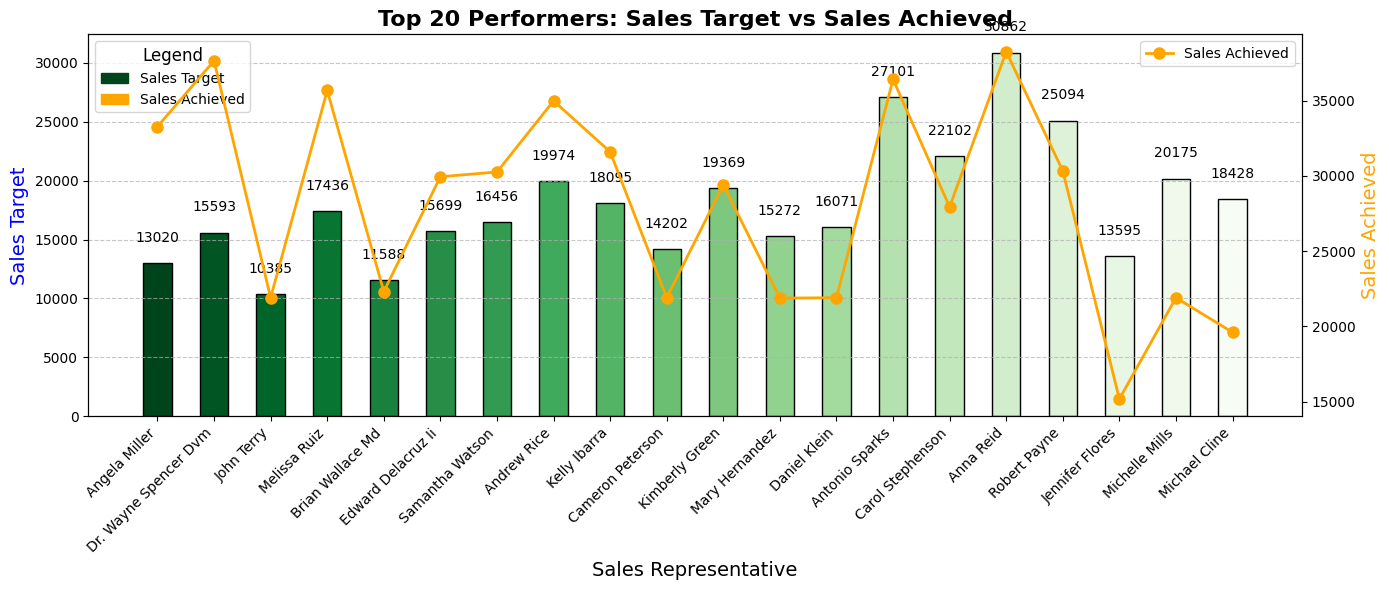

In [37]:
# Assuming 'sales_team_df' is a Spark DataFrame, first convert it to a Pandas DataFrame for further processing
sales_team_pd_df = sales_team_df.toPandas()

# Calculate the Sales Achievement Rate
sales_team_pd_df['Achievement_Rate (%)'] = (sales_team_pd_df['Sales_Achieved'] / sales_team_pd_df['Sales_Target']) * 100

# Sort by achievement rate to highlight top performers and select the top 20
top_20_performers = sales_team_pd_df.sort_values(by='Achievement_Rate (%)', ascending=False).head(20)
logger.info('Top 20 Performers: Sales Target vs Sales Achieved')
plot_dual_axis_bar_line(
    data_pd=top_20_performers,             # DataFrame with top 20 performers
    x_labels='Name',                       # Column for y-axis (sales rep names)
    bar_col='Sales_Target',                # Column for bar plot (Sales Target)
    line_col='Sales_Achieved',             # Column for line plot (Sales Achieved)
    bar_label='Sales Target',              # Label for the bar plot
    line_label='Sales Achieved',           # Label for the line plot
    title='Top 20 Performers: Sales Target vs Sales Achieved',  # Plot title
    x_title='Sales Representative',        # X-axis label
    bar_y_title='Sales Target',            # Y-axis label for the bar plot
    line_y_title='Sales Achieved',         # Y-axis label for the line plot
    cmap='Greens',                          # Colormap for bars
    line_color='orange'                    # Color for the line plot
)


In [38]:
spark.stop()